# Determination of the object's positions and orientations with respect to the image coordinate frame.

Importing libraries

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import io 
import math
import pandas as pd
from matplotlib.patches import Ellipse


Code for projectIII, not calling the function from the ntnu/faai respository!

In [2]:
def show_channels(im, channel_names=None, colormap='gray'):

    plt.figure(figsize=(15, 4))

    for ch in range(3):

        plt.subplot(1, 3, ch+1)
        plt.imshow(im[:, :, ch], cmap=colormap, vmin=0, vmax=255)
        plt.axis('off')
        
        title = 'Channel {}'.format(ch+1)
        if channel_names is not None:
            title += ' ({})'.format(channel_names[ch])
        
        plt.title(title)

        

def find_ccomp(im, *args, **kwargs):
   

    num, labels, stats, centroids = cv2.connectedComponentsWithStats(im, *args, **kwargs)
    
    stats_df = pd.DataFrame(stats, columns=['left', 'top', 'width', 'height', 'area'])
    stats_df['x'] = centroids[:,0]
    stats_df['y'] = centroids[:,1]
    
    return labels, stats_df    



def plot_bbox(x, y, w, h, **kwargs):
    

    if kwargs == {}:
        kwargs = {'color': 'cyan'}
        
    lines = [
        [x, y, x+w, y],
        [x, y, x, y+h],
        [x+w, y, x+w, y+h],
        [x, y+h, x+w, y+h],
    ]

    for line in lines:
        plot_line(line, **kwargs)
        
        
    

def viz_ellipses(im, ellipses_data):

    a = plt.subplot(111)

    plt.imshow(im)
    
    for x, y, d1, d2, theta in ellipses_data:
    
        plt.plot(x, y, 'ro')

        ellipse = Ellipse([x, y], d1, d2, math.degrees(theta))
        ellipse.set_alpha(0.5)

        a.add_artist(ellipse)


In [3]:
def threshold_binary(im, t):       
    _, im_t = cv2.threshold(im, t, 255, cv2.THRESH_BINARY)
    return im_t



def threshold_binary_inv(im, t):       
    _, im_t = cv2.threshold(im, t, 255, cv2.THRESH_BINARY_INV)
    return im_t



def mask_threshold_range(im, thresh_min, thresh_max):
    binary_output = (im >= thresh_min) & (im < thresh_max)
    return np.uint8(binary_output)



def imshow(im, **kwargs):
    plt.imshow(im, **kwargs)
    plt.axis('off')
    plt.show()
    

    

def apply_mask(im, mask):

    return cv2.bitwise_and(im, im, mask=mask)



def plot_line(line, **kvargs):

    xs = [line[0], line[2]]
    ys = [line[1], line[3]]

    plt.plot(xs, ys, '-', **kvargs)



def region_ellipse_from_moments(im_binary):
  
    
    m = cv2.moments(im_binary, binaryImage=True)
    
    area = m['m00']

    center_x = m['m10'] / area
    center_y = m['m01'] / area
    
    mu20 = m['mu20'] / area
    mu02 = m['mu02'] / area
    mu11 = m['mu11'] / area
    
    s = np.sqrt((mu20 - mu02)**2 + 4 * mu11**2)
    d1 = 2 * np.sqrt(2 * (mu20 + mu02 + s))
    d2 = 2 * np.sqrt(2 * (mu20 + mu02 - s))
    
    theta = 0.5 * math.atan(2 * mu11 / (mu20 - mu02))
    
    if mu20 < mu02:
        theta += math.pi/2
        
    return center_x, center_y, d1, d2, theta


Opening the image and changing into Gray Scale using cv2 function.

In [4]:

imgCard = cv2.imread("Cards.jpg")

imgGray = cv2.cvtColor(imgCard, cv2.COLOR_BGR2GRAY)

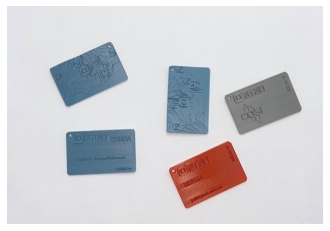

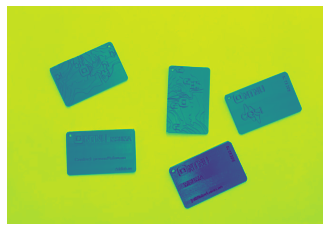

In [5]:
imshow(imgCard)
imshow(imgGray)

Region of Interest of the image!

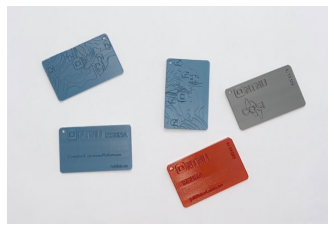

In [6]:
ROI_image = imgCard[20:1100, 20:700]

imshow(ROI_image)

# Image Channel

Exploring image Channel!

An RGB image has three channels: red, green, and blue. RGB channels roughly follow the color receptors in the human eye, and are used in computer displays and image scanners.

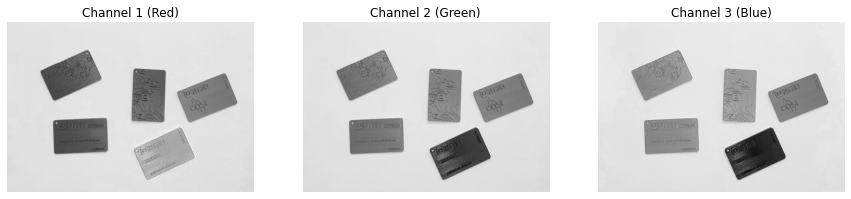

In [7]:
show_channels(imgCard, channel_names=['Red', 'Green', 'Blue'])

Image thresholding in the green channel!

In [8]:
imgRed = imgCard[:, :, 0] # 0 - red, 1 - green, 2 - blue
imgGreen = imgCard[:, :, 1] # 0 - red, 1 - green, 2 - blue
imgBlue = imgCard[:, :, 2] # 0 - red, 1 - green, 2 - blue

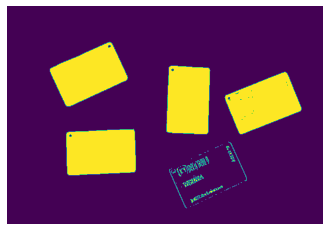

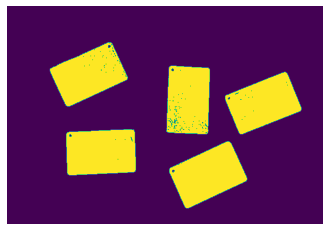

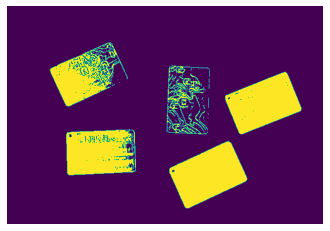

In [9]:
RedMask_Card = threshold_binary_inv(imgRed, 150)
GreenMask_Card = threshold_binary_inv(imgGreen, 150)
BlueMask_Card = threshold_binary_inv(imgBlue, 150)

imshow(RedMask_Card)
imshow(GreenMask_Card)
imshow(BlueMask_Card)


# HSV Color Conversion


HSV (for hue, saturation, value; also known as HSB, for hue, saturation, brightness) are alternative representations of the RGB color model. HSV representation models how colors appear under light.

(456, 662, 3)


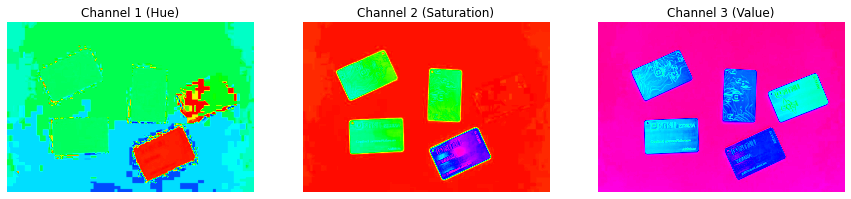

In [10]:
HSV_image = cv2.cvtColor(imgCard, cv2.COLOR_RGB2HSV)

print(HSV_image.shape)

show_channels(HSV_image, channel_names=['Hue', 'Saturation', 'Value'], colormap='hsv')

Hue channel thresholding!

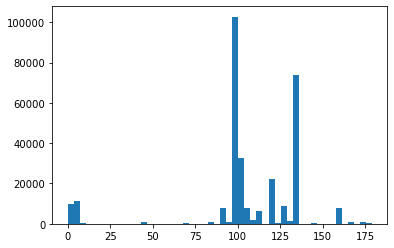

In [11]:
plt.hist(HSV_image[:, :, 0].ravel(), bins=50)
plt.show()

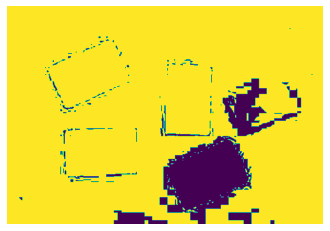

In [12]:
HSV_image_GreenMask = mask_threshold_range(HSV_image[:, :, 0], 75, 150)
imshow(HSV_image_GreenMask)

# Image Dilation and Erosion using cv2

Image Dilation and Erosion are morphological operations that operates the images based on shapes. They apply a structuring element to an input image and generate an output image. Basics of Erosion:Erodes away the boundaries of the foreground object
and used to diminish the features of an image. Basics of Erosion : Increases the object area and used to accentuate features.

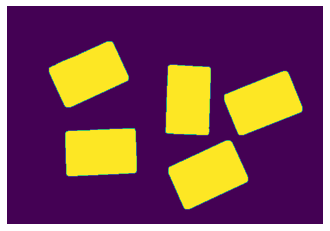

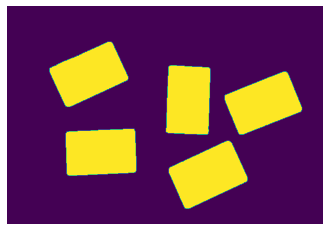

In [13]:
kernel = np.ones((3,3),np.uint8)


imgDilated = cv2.dilate(GreenMask_Card,kernel,iterations=2)

imshow(imgDilated)

imgEroded = cv2.erode(imgDilated, kernel, iterations=1)

imshow(imgEroded)


# Canny edge detection using cv2

The Canny Edge detector also known as the optimal detector, the Canny algorithm aims to satisfy three main criteria:
Low error rate: Meaning a good detection of only existent edges.
Good localization: The distance between edge pixels detected and real edge pixels have to be minimized.
Minimal response: Only one detector response per edge.


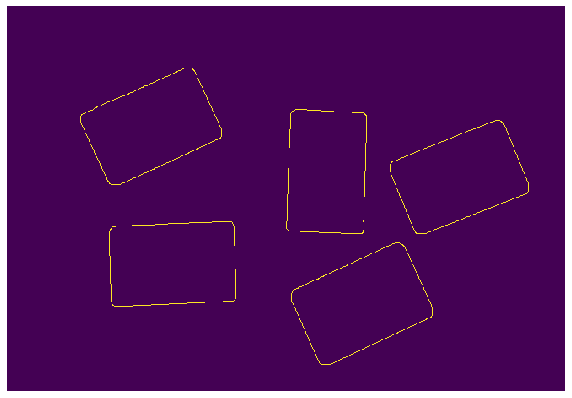

In [14]:
imgCanny = cv2.Canny(imgDilated, 30, 100)

plt.figure(figsize=(10, 15))
plt.imshow(imgCanny, interpolation='none')
plt.axis('off')
plt.show()

# Binary Masking

A mask is a binary image consisting of zero- and non-zero values. Mask is applied to another binary or to a grayscale image of the same size, all pixels which are zero in the mask are set to zero in the output image. All others remain unchanged. It is often used to restrict a point or arithmetic operator to an area defined by the mask.

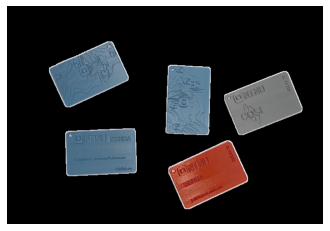

In [15]:
imgMasked = apply_mask(imgCard, imgDilated)

imshow(imgMasked)

Detecting connected components after Masking

In [16]:
ccomp_labels, ccomp_stats = find_ccomp(imgEroded)

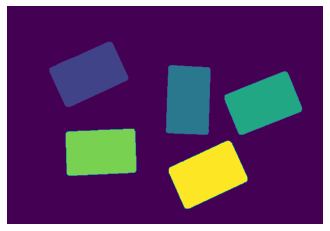

In [17]:
imshow(ccomp_labels)

In [18]:
ccomp_stats

,left,top,width,height,area,x,y
0,0,0,662,456,235697,327.807435,223.472709
1,89,75,165,136,13164,170.701231,142.366682
2,333,124,93,145,12557,379.364020,196.488174
3,456,137,162,132,13073,536.228792,202.697621
4,123,257,148,98,13518,196.406495,305.300636
5,339,282,165,142,13863,420.510712,352.427036


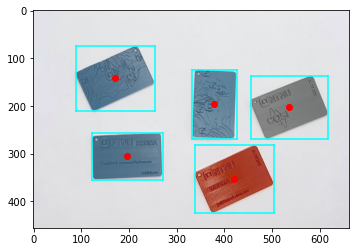

In [19]:
plt.imshow(imgCard)

# plot centroids
plt.scatter(ccomp_stats.iloc[1:].x, ccomp_stats.iloc[1:].y, color='red')

# plot bounding boxes
# skip first row
for idx in ccomp_stats.index[1:]:
    
    row = ccomp_stats.iloc[idx]
    
    plot_bbox(row.left, row.top, row.width, row.height)
    
plt.show()

# Equivalent Ellipse

In [20]:
parts_df = ccomp_stats.iloc[1:]

ellipses_data = []

for i in parts_df.index:
    
    part_mask = np.array(ccomp_labels == i, dtype=np.uint8)

    ellipse_tuple = region_ellipse_from_moments(part_mask)
    print(i, ellipse_tuple)
    
    ellipses_data.append(ellipse_tuple)

1 (170.70123062898816, 142.36668185961713, 167.17432471550208, 104.62239865595402, -0.41818176169134347)
2 (379.3640200684877, 196.48817392689335, 163.2175356529382, 102.3483246339845, 1.5953152554868626)
3 (536.2287921670619, 202.6976210510212, 165.2888005048725, 105.00772859518676, -0.37064791275183956)
4 (196.40649504364552, 305.30063618878535, 168.44263284039093, 106.70086151658977, -0.05421186433629757)
5 (420.51071196710666, 352.42703599509485, 168.10177435071455, 109.51087716710016, -0.4456111588280066)


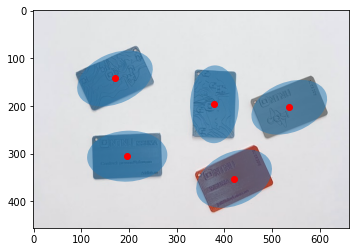

In [21]:
viz_ellipses(imgCard, ellipses_data)